<a href="https://colab.research.google.com/github/choki0715/lecture/blob/master/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
# 독일 예나지역 기상 데이터 다운로드 
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
# 학습 데이터 / 검증 데이터 분리 
TRAIN_SPLIT = 300000

df = pd.read_csv(csv_path)

df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# 분석에 사용할 특성추출 
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)']
features = df[features_considered]
features.head()


,p (mbar),T (degC),rho (g/m**3),VPact (mbar),VPdef (mbar),sh (g/kg)
0,996.52,-8.02,1307.75,3.11,0.22,1.94
1,996.57,-8.41,1309.80,3.02,0.21,1.89
2,996.53,-8.51,1310.24,3.01,0.20,1.88
3,996.51,-8.31,1309.19,3.07,0.19,1.92
4,996.51,-8.27,1309.00,3.08,0.19,1.92


In [ ]:

# 항목명을 제외한 데이터만 추출
dataset = features.values

# 넘파이를 이용한 평균값과 표준편차 계산
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# 정규화
dataset = (dataset-data_mean)/data_std
dataset

array([[ 0.95547359, -1.99766294,  2.2350791 , -1.49712208, -0.78874946,
        -1.50013079],
       [ 0.96154485, -2.04281897,  2.28524007, -1.51840938, -0.79083026,
        -1.51876137],
       [ 0.95668784, -2.05439744,  2.29600633, -1.52077464, -0.79291106,
        -1.52248748],
       ...,
       [ 1.35617678, -1.43494935,  1.76136375, -1.45691272, -0.51200281,
        -1.45914353],
       [ 1.35496252, -1.55883897,  1.88786728, -1.47583477, -0.57234607,
        -1.48150022],
       [ 1.35617678, -1.62715193,  1.95686921, -1.468739  , -0.61812371,
        -1.47404799]])

In [ ]:
# 학습데이터 --> 입력데이터, 레이블 작성 
def dataset_build(dataset, target, start_index, end_index, past_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + past_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-past_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
# 어느정도 과거 데이터로 미래를 예측할 지 파라메터 설정
past_timestep = 120
future_timestep = 12
# 데이터 생성시 stride 거리
STEP = 1

x_train, y_train = dataset_build(dataset, dataset[:, 1], 0,
                                  TRAIN_SPLIT, past_timestep,
                                  future_timestep, STEP)
x_val, y_val = dataset_build(dataset, dataset[:, 1],
                               TRAIN_SPLIT, None, past_timestep,
                               future_timestep, STEP)

In [ ]:
print (' Single window of past timesteps : {}'.format(x_train[0].shape))
print ('\n Target temperatures to predict : {}'.format(y_train[0].shape))

 Single window of past timesteps : (120, 6)

 Target temperatures to predict : (12,)


In [ ]:
# 한번에 입력할 데이터 수량
BATCH_SIZE = 256

# 셔플링할때 목표 데이터 수량
BUFFER_SIZE = 300000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()


val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [ ]:
# 시간축 x 값 생성 
def build_time_steps(length):
  return list(range(-length, 0))

def result_plot(past, true_future, pred_future):
  plt.figure(figsize=(12, 6))
  num_in = build_time_steps(len(past))
  num_out = len(true_future)

  plt.plot(num_in, np.array(past[:, 1]), label='Past')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-',
           label='True Future')
  if pred_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(pred_future), 'r-',
             label='Pred Future')
  plt.legend(loc='upper left')
  plt.show()

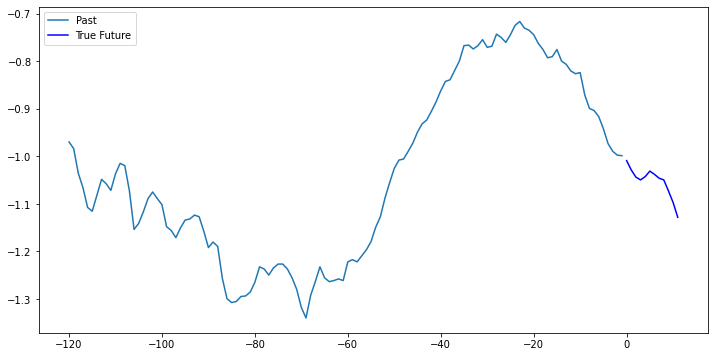

In [ ]:
for x, y in train_data.take(1):
  result_plot(x[0], y[0], np.array([0]))

In [44]:
# GRU 기반의 시계열 예측모델
model = tf.keras.Sequential([
     tf.keras.layers.GRU(32, activation='relu', return_sequences=True),
     tf.keras.layers.GRU(32, activation='relu', return_sequences=True),
     tf.keras.layers.GRU(32, activation='relu'),

    # 중요: Dense(N) = future_timestep (N)
     tf.keras.layers.Dense(12)
     ])


# RMSprop 최적화 함수 사용. MSE 로스 함수 적용
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')


In [45]:
# 데이터 포맷 및 크기 확인
for x, y in val_data.take(1):
  print (model.predict(x).shape)

(256, 12)


In [46]:
# 반복 학습 횟수
EVALUATION_INTERVAL = 200

# 학습 에포크 정의
EPOCHS = 2

# 학습 시작 
model.fit(train_data, epochs=EPOCHS, 
          steps_per_epoch=EVALUATION_INTERVAL,
          validation_data=val_data,
          validation_steps=50)
          

Epoch 1/2
200/200 [==============================] - 69s 318ms/step - loss: 0.0979 - val_loss: 0.0143
Epoch 2/2
200/200 [==============================] - 64s 319ms/step - loss: 0.0202 - val_loss: 0.0116


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_45 (GRU)                (None, 120, 32)           3840      
                                                                 
 gru_46 (GRU)                (None, 120, 32)           6336      
                                                                 
 gru_47 (GRU)                (None, 32)                6336      
                                                                 
 dense_15 (Dense)            (None, 12)                396       
                                                                 
Total params: 16,908
Trainable params: 16,908
Non-trainable params: 0
_________________________________________________________________


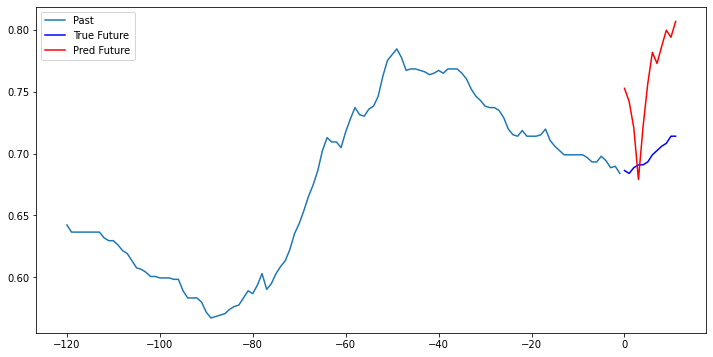

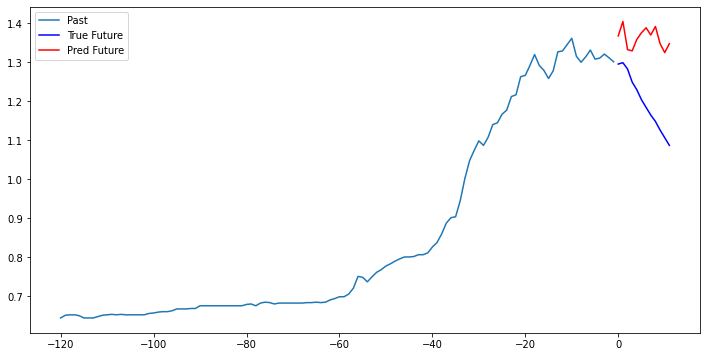

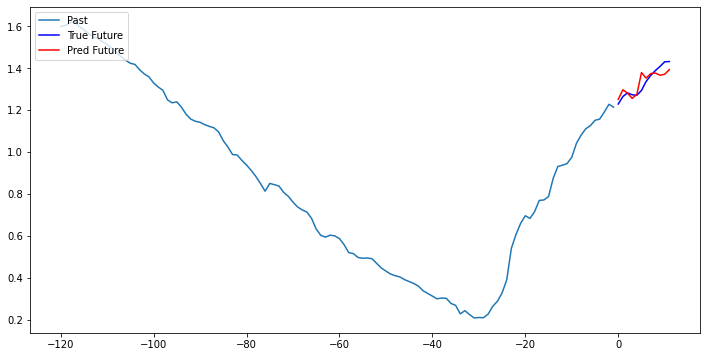

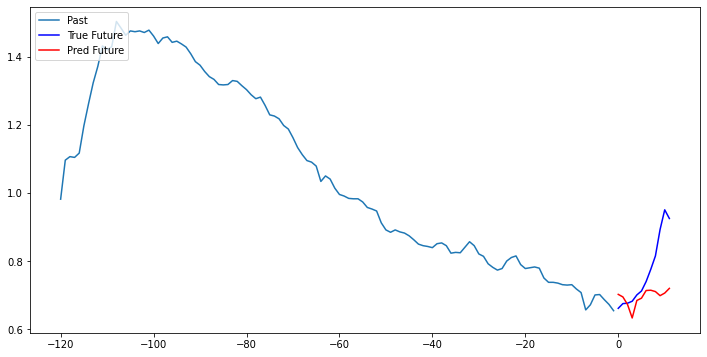

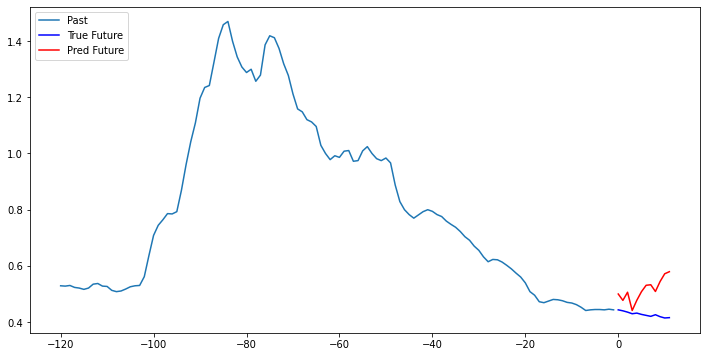

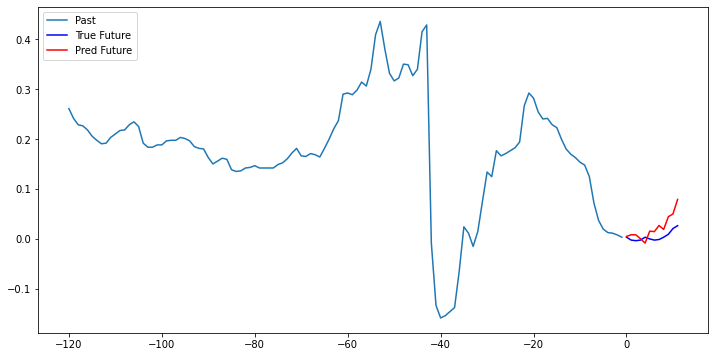

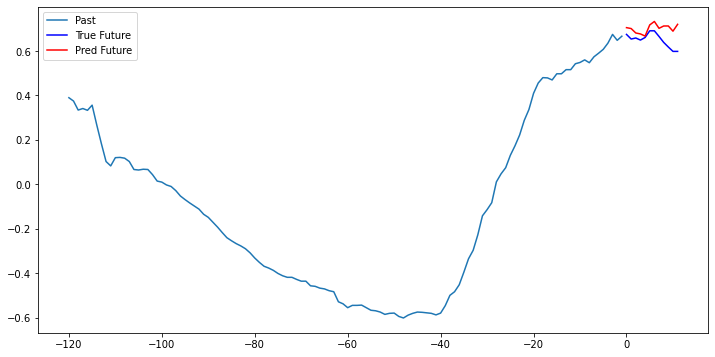

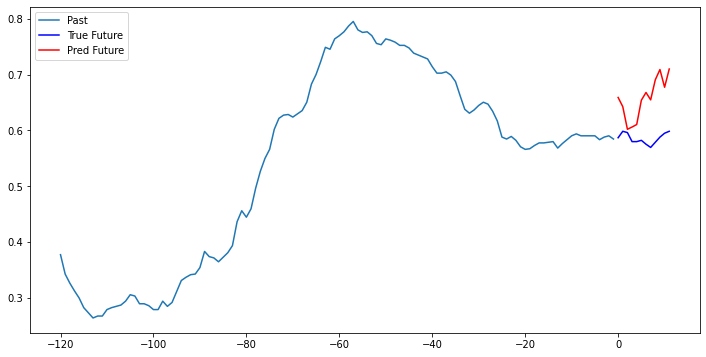

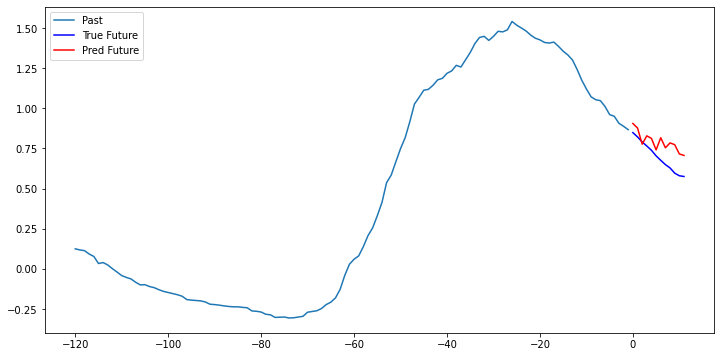

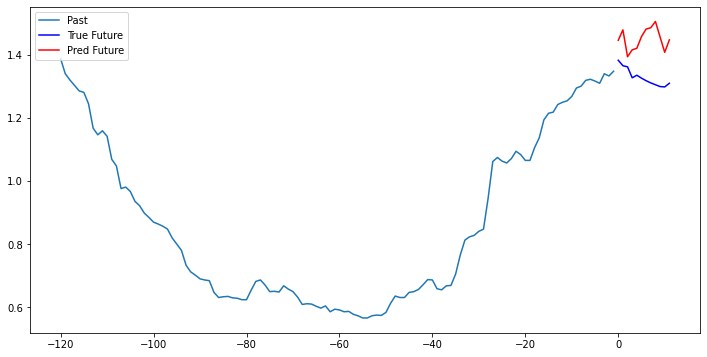

In [47]:
# 검증: 예측 결과 출력
model.summary()
for x, y in val_data.take(10):
  result_plot(x[0], y[0], model.predict(x)[0])